# End-to-End Data Science Project
## Predicting Income with the UCI Adult Dataset

This notebook walks through a basic **data science project** using the classic [UCI Adult ("Census Income") dataset](https://archive.ics.uci.edu/dataset/2/adult).

We will cover the main stages of the data science lifecycle:

1. **Problem definition & dataset overview**  
2. **Exploratory Data Analysis (EDA)**  
3. **Data preprocessing** (handling missing values, encoding categoricals, scaling)  
4. **Training classification models**  
5. **Evaluating model performance**  
6. **Hyperparameter tuning with Optuna**  
7. **Training a final model**

Throughout the notebook, some code cells are intentionally left **incomplete** with `TODO` comments. These are exercises for you to fill in by reading the docs and trying things out yourself.


## 0. Setup

In this section we:

- Install the Python libraries we will use.
- Import them into our environment.

Why this matters:
- Real-world projects usually rely on a set of standard libraries (e.g., `pandas`, `scikit-learn`).
- Reproducibility matters: having an explicit install cell makes it easier to run this notebook on a fresh machine.

**Resources**:
- pandas installation and docs: https://pandas.pydata.org/docs/  
- scikit-learn installation and docs: https://scikit-learn.org/stable/  
- Optuna docs (hyperparameter tuning): https://optuna.readthedocs.io/


In [ ]:
# If you're running in an environment like Google Colab, you can run this cell.
# If everything is already installed (e.g., on your local machine), you can skip it.
%pip install -q pandas numpy matplotlib seaborn scikit-learn optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.8 MB/s eta 0:00:00


In [ ]:
import numpy as np #!
import pandas as pd #!
import matplotlib.pyplot as plt #!
import seaborn as sns #!

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import optuna
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Problem Definition & Dataset Overview

**Goal:** Predict whether a person's annual income is **greater than $50K** using census features.

This is a **binary classification** problem:

- Target variable: `income` (e.g., `<=50K` vs `>50K`)  
- Features: age, education, occupation, hours per week, etc.

Why this matters:
- Clearly defining the problem guides the choice of algorithms, metrics, and preprocessing steps.
- Understanding the dataset structure helps you design your EDA and modeling strategy.

**Dataset**:
- UCI Adult / Census Income dataset: https://archive.ics.uci.edu/dataset/2/adult  
- Original description: https://archive.ics.uci.edu/ml/datasets/census+income

**Exercise** (mental, no code yet):
- What kinds of features might be useful for predicting income?  
- Which ones might be noisy or less helpful?


### 1.1 Loading the Data

We will load the Adult dataset from a local file. The original UCI site provides files such as `adult.data` (training) and `adult.test`.

For simplicity, we'll assume you have downloaded `adult.data` to a `data/` folder.

**Why this matters:**
- Real-world data rarely comes pre-loaded. You often need to read from CSV, databases, APIs, etc.

**Resources**:
- pandas `read_csv` documentation: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html


In [ ]:
# TODO: Update this path to wherever you saved the Adult dataset file.
train_path = 'data/adult.data'  # e.g., 'adult.data' or a full path is in folder.

# Column names from the UCI Adult dataset description
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]

# NOTE: The original dataset encodes missing values as ' ?'.
df = pd.read_csv(
    train_path,
    header=None,
    names=column_names,
    na_values=' ?',
    skipinitialspace=True,
)

df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# TODO: Use the methods below to get a quick feel for the data.
# 1. Look at the first few rows.
# 2. Check the shape (rows, columns).
# 3. Inspect basic information about dtypes and non-null counts.
# 4. Get summary statistics for numeric columns.

# HINTS:
# - df.head()
# - df.shape
# - df.info()
# - df.describe()

# Your code here
df.head(10)
df.shape
df.info()
df.describe()

df[['sex','hours_per_week']].head(20) #display two rows of data
df[['sex','race','hours_per_week']].head(20)

df.groupby('sex')['hours_per_week'].mean() #groupby for aggregation and understanding data
df.groupby('race')['hours_per_week'].mean()
df.groupby('sex')['hours_per_week'].sum()
df.groupby('race')['hours_per_week'].sum()

#income not numeric, use apply. to run lambda expression that maps innqeuality to a number
df.groupby('race')['income'].apply(lambda x: x.map({'<=50K': 0, '>50K': 1}).mean())
df.groupby('sex')['income'].apply(lambda x: x.map({'<=50K': 0, '>50K': 1}).mean())
df.groupby('race')['income'].apply(lambda x: x.map({'<=50K': 0, '>50K': 1}).sum())
df.groupby('sex')['income'].apply(lambda x: x.map({'<=50K': 0, '>50K': 1}).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,income
sex,
Female,1179
Male,6662


## 2. Exploratory Data Analysis (EDA)

EDA is about **getting to know your data** before you build any models.

In this section we will:
- Check for missing values and data quality issues.
- Look at distributions of key variables.
- Explore relationships between features and the target.

Why this matters:
- Helps you spot data quality problems early (missing values, outliers, strange categories).
- Guides feature engineering and model choice.
- Prevents you from treating the dataset as a black box.

**General EDA resources**:
- pandas user guide: https://pandas.pydata.org/docs/user_guide/index.html  
- A beginner-friendly pandas tutorial: https://www.datacamp.com/tutorial/pandas


### 2.1 Missing Values, Duplicates, and Basic Data Quality

First, let's check:
- How many missing values each column has.
- Whether there are any duplicated rows.

**Resources**:
- pandas `isna` / `isnull`: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html  
- pandas `duplicated`: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html


In [ ]:
# Count missing values per column (no missing values, ?)
df.isna().sum().sort_values(ascending=False)


,0
age,0
workclass,0
fnlwgt,0
education,0
education_num,0
marital_status,0
occupation,0
relationship,0
race,0
sex,0


In [ ]:
# TODO: Check how many duplicate rows there are in the dataset.
# HINT: Use df.duplicated().sum()

# Your code here

df.duplicated()
df.duplicated().sum() # 24 replica rows


np.int64(24)

In [ ]:
# Let's also look at the distribution of the target variable (income).
df['income'].value_counts(normalize=True)


,proportion
income,
<=50K,0.75919
>50K,0.24081


### 2.2 Univariate Distributions (Single-Variable Plots)

Next, we look at the distribution of individual features (e.g., age, hours per week).

**Why this matters:**
- Helps you see typical ranges, skewness, and outliers.
- For categorical variables, you can see which categories are common or rare.

**Resources**:
- pandas plotting: https://pandas.pydata.org/docs/user_guide/visualization.html  
- seaborn `histplot` and `countplot`: https://seaborn.pydata.org/tutorial/distributions.html


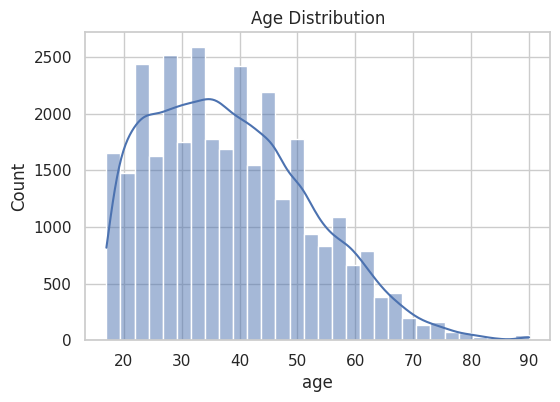

In [ ]:
# Example: distribution of age
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='age', bins=30, kde=True)
plt.title('Age Distribution')
plt.show() #numerical/categorical

#both seaborn and pandas use matlab so we dont need to pass sns to show or vice versa


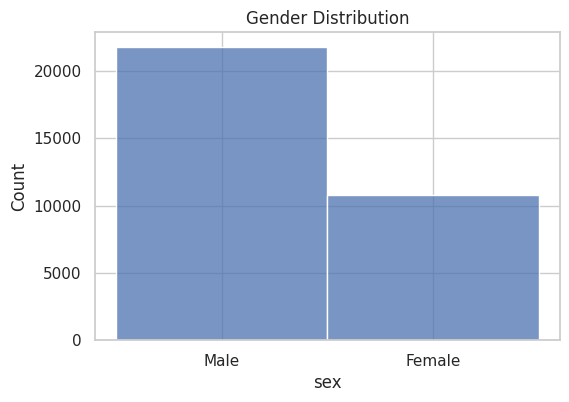

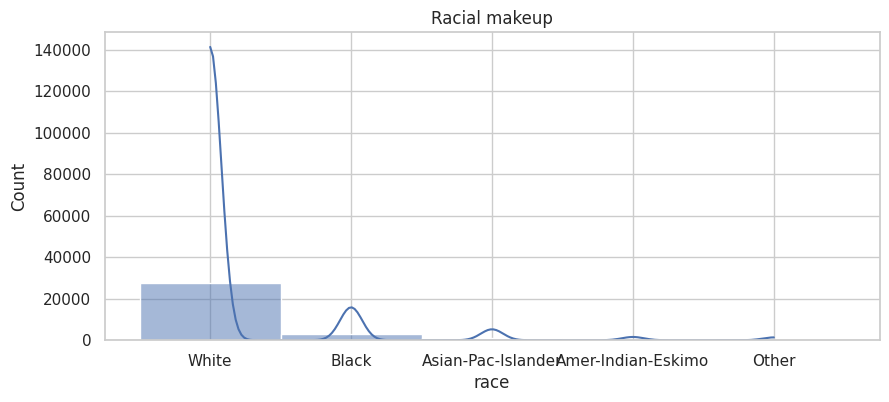

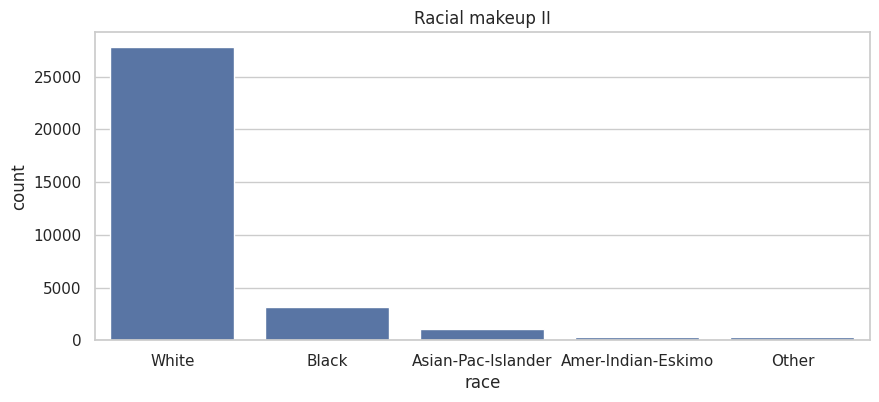

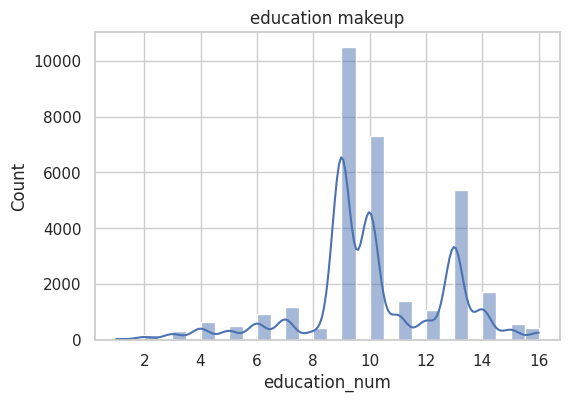

In [ ]:
# TODO: Pick another numeric column (e.g., 'hours_per_week') and plot its distribution.
# Use seaborn.histplot or pandas.DataFrame.hist.

# Your code here
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='sex', bins=30)
plt.title('Gender Distribution')
plt.show() #categorical should use countplot intead

plt.figure(figsize=(10,4))
sns.histplot(data=df,x='race',bins=35,kde=True)
plt.title('Racial makeup')
plt.show() #categorical should use countplot intead

#determine when for categorical and non cargorical display,better
#numeric=histo,box,kde
#categorical=count, bar
#numeric by categorical=box,violin,bar



plt.figure(figsize=(10,4))
sns.countplot(data=df,x='race')
plt.title('Racial makeup II')
plt.show() # countplot

plt.figure(figsize=(6,4))
sns.histplot(data=df,x='education_num', bins=30,kde=True)
plt.title('education makeup')
plt.show() #histplot/kde









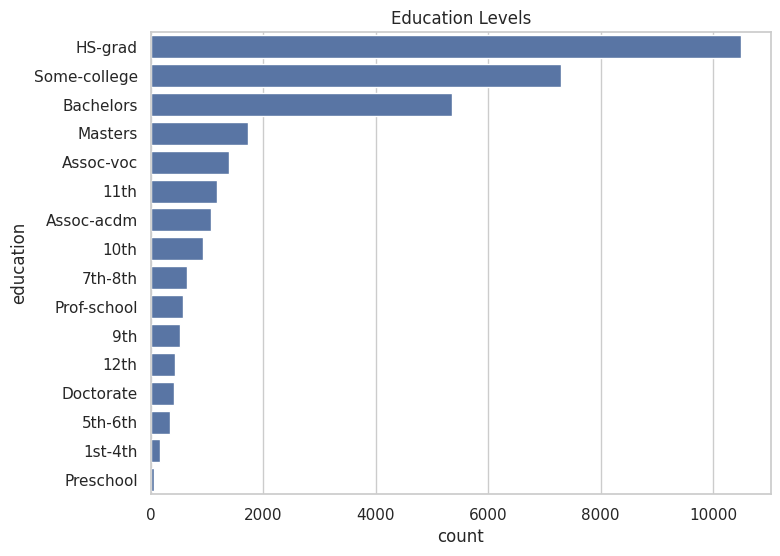

In [ ]:
# Example: distribution of a categorical variable (education)
plt.figure(figsize=(8,6))
sns.countplot(data=df, y='education', order=df['education'].value_counts().index)
plt.title('Education Levels')
plt.show()


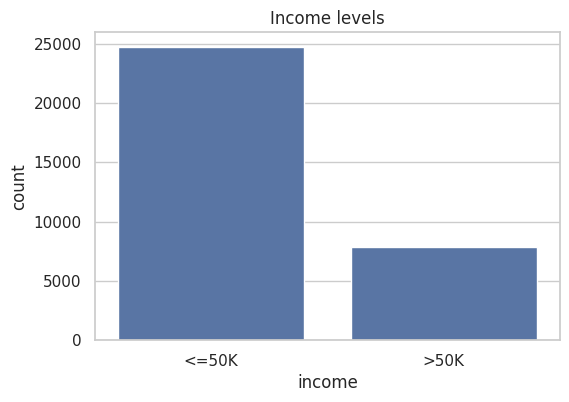

In [ ]:
# TODO: Plot the distribution of the target variable 'income'.
# HINT: seaborn.countplot(data=df, x='income')

# Your code here
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='income')
plt.title('Income levels')
plt.show()



### 2.3 Relationships Between Features and Target

Now let's explore **how features relate to the target** `income`.

Examples:
- Distribution of age split by income group.
- Proportion of `>50K` by education level or marital status.

**Why this matters:**
- Helps you build intuition about which variables might be predictive.
- Can inspire feature engineering ideas.

**Resources**:
- seaborn `boxplot`, `violinplot`, `catplot`: https://seaborn.pydata.org/api.html


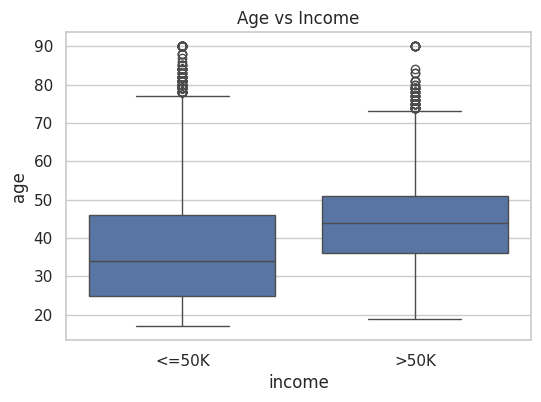

In [ ]:
# Example: age vs income
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='income', y='age')
plt.title('Age vs Income')
plt.show()


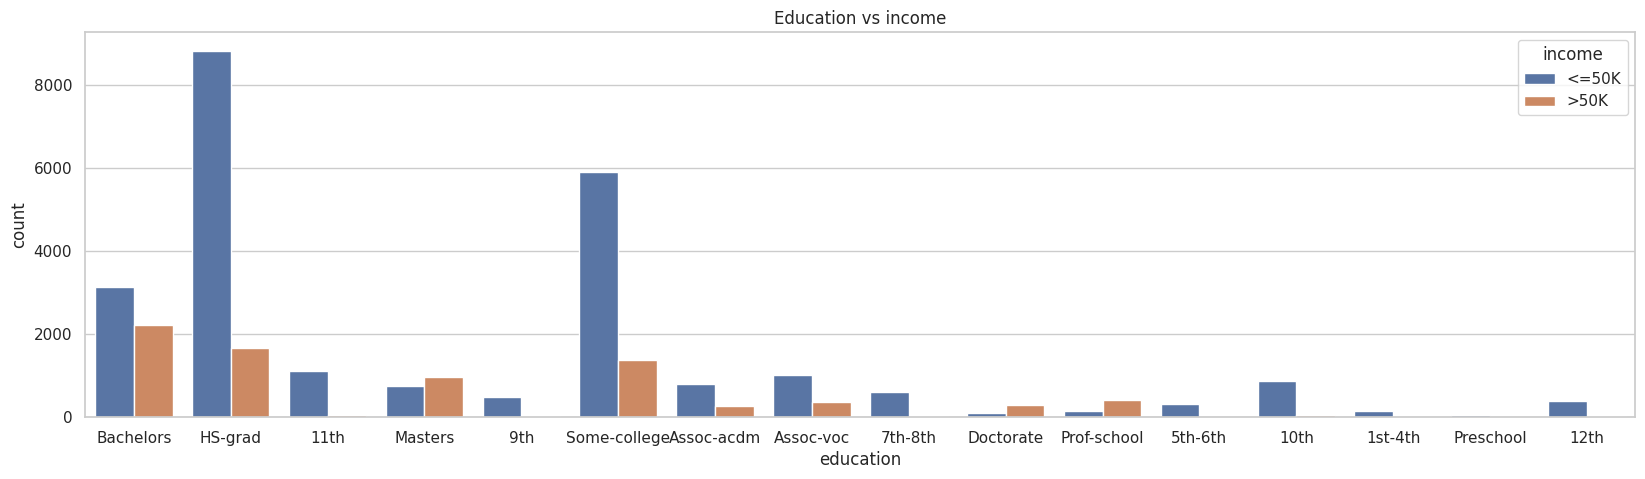

<Figure size 700x700 with 0 Axes>

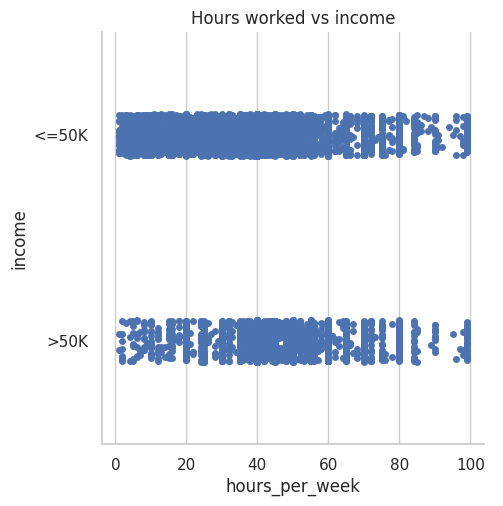

<Figure size 700x700 with 0 Axes>

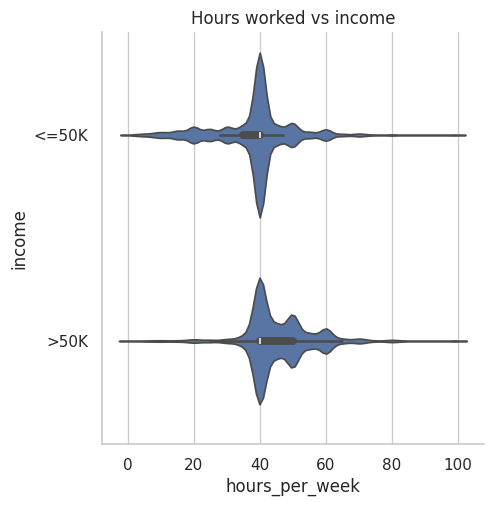

<Figure size 700x700 with 0 Axes>

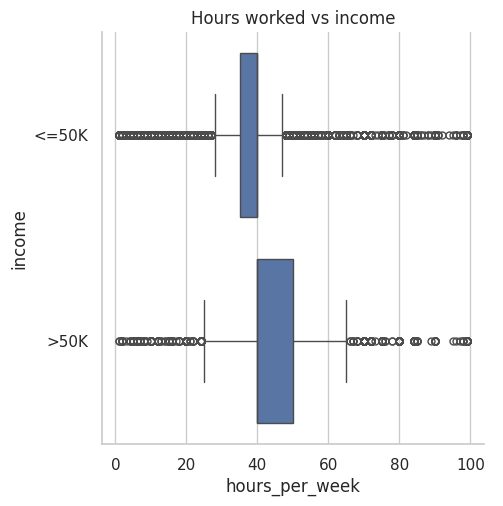

In [ ]:
# TODO: Create at least one more plot that relates a feature to income.
# Ideas:
# - Use seaborn.countplot for 'education' vs 'income'.
# - Use seaborn.catplot for 'hours_per_week' vs 'income'.



# Your code here

#countplot for education vs income...countplot shows count of education numbers (+ hue)
plt.figure(figsize=(20,5))
sns.countplot(data=df,x='education',hue='income')
plt.title('Education vs income')
plt.show()

#catplot for hours worked vs income
plt.figure(figsize=(7,7))
sns.catplot(data=df, x='hours_per_week',y='income')
plt.title('Hours worked vs income')
plt.show()

#violin cat plot
plt.figure(figsize=(7,7))
sns.catplot(data=df, x='hours_per_week',y='income', kind='violin')
plt.title('Hours worked vs income')
plt.show()

#boxplot catplot
plt.figure(figsize=(7,7))
sns.catplot(data=df, x='hours_per_week',y='income', kind='box')
plt.title('Hours worked vs income')
plt.show()


## 3. Data Preprocessing

Machine learning models typically expect **clean, numeric input** with no missing values.

In this section we will:
- Separate features (`X`) and target (`y`).
- Identify numeric vs categorical features.
- Build preprocessing pipelines to:
  - Impute missing values.
  - Scale numeric features.
  - One-hot encode categorical features.

**Why this matters:**
- Good preprocessing can significantly improve model performance and stability.
- Pipelines make your code cleaner and help avoid data leakage.

**Resources**:
- Scikit-learn preprocessing overview: https://scikit-learn.org/stable/modules/preprocessing.html  
- `ColumnTransformer`: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html  
- `Pipeline`: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


In [ ]:
# Separate features and target
df['income'].unique()

X = df.drop('income', axis=1) #feature arguement holds everything EXCEPT income
y = df['income'].map({'>50K': 1, '<=50K': 0}) #target x

# IMPORTANT: If your target values look different (e.g., with spaces),
# print df['income'].unique() and adjust the mapping accordingly.


In [ ]:
# Identify numeric and categorical columns
numeric_features = [
    'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'
]
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_features, categorical_features


(['age',
  'fnlwgt',
  'education_num',
  'capital_gain',
  'capital_loss',
  'hours_per_week'],
 ['workclass',
  'education',
  'marital_status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native_country'])

In [ ]:
# Build preprocessing pipelines for numeric and categorical columns
numeric_transformer = Pipeline(steps=[  #numeric pipleine "for # values here is what we do"
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(  #the actual preprocessing line
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


In [ ]:
# TODO: Fit the preprocessor on X and transform the data to see the resulting shape.
# HINTS:
# - X_preprocessed = preprocessor.fit_transform(X)
# - X_preprocessed.shape

# Your code here



#original
#X.shape #(32561x14)


#preprocessed
#X_preprocessed #(32561x108)


preprocessor.fit_transform(X) #one simple line


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 455854 stored elements and shape (32561, 108)>

## 4. Train/Test Split and Baseline Model

Before training models, we need to split our data into **training** and **test** sets.

- **Training set**: used to fit (learn) the model parameters.
- **Test set**: held-out data to evaluate how well the model generalizes.

We'll start with a simple **Logistic Regression** model as our baseline classifier.

**Resources**:
- Train/test split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression (classification): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


In [ ]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, #20% used for test
    random_state=RANDOM_STATE,
    stratify=y, #proportion of >50 and <=50
)

X_train.shape, X_test.shape


#train set used for learning (patterns)
#test set used for evaluating
#our case, train on some people test on others
#without splitting predictive model memorize patterns and "overfit" casuing false sense of accuracy

((26048, 14), (6513, 14))

In [ ]:
# Build a pipeline: preprocessing + logistic regression classifier
log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, n_jobs=-1)),
])

log_reg_clf.fit(X_train, y_train)

#logistic regression predicts the 50k # and assigns coefficient (weight) to features (age,hours,ect) generating a "score" that establishs prediction


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('model', LogisticRegression(max_iter=1000, n_jobs=-1))])

## 5. Evaluating the Baseline Model

Once we have a trained model, we need to evaluate how well it performs.

Common classification metrics:
- **Accuracy**: overall fraction of correct predictions.
- **Precision & Recall**: especially important for imbalanced classes.
- **F1-score**: harmonic mean of precision and recall.
- **Confusion matrix**: shows counts of true vs predicted labels.

**Resources**:
- Classification metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics


Logistic Regression Accuracy: 0.856

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



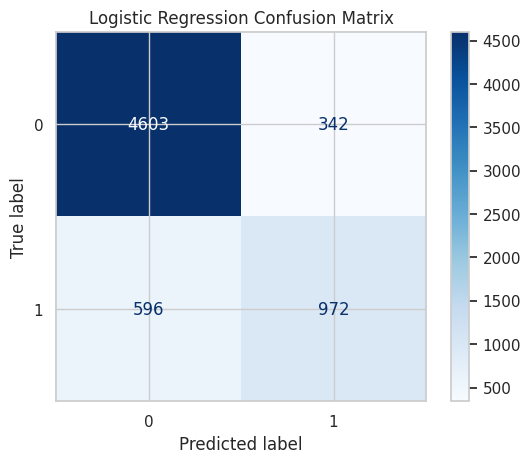

In [ ]:
y_pred = log_reg_clf.predict(X_test) #after train predict

acc = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {acc:.3f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_clf.classes_)
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


In [ ]:
# TODO: Perform cross-validation on the training set to get a more robust estimate of performance.
# HINT: use cross_val_score with the log_reg_clf pipeline and X_train, y_train.
# Example: scores = cross_val_score(log_reg_clf, X_train, y_train, cv=5, scoring='accuracy')
# Then print the mean and standard deviation.

#5fold cross check means 5 validations



# Your code here
scores = cross_val_score(log_reg_clf, X_train, y_train, cv=5, scoring='accuracy')
#we call the mean/std on check scores
#5scores 1 mean
#5scores 1 std
print(scores.mean(), scores.std())


0.8508904380392861 0.0046780210379279595


## 6. Trying a More Powerful Model: Random Forest

A **Random Forest** is an ensemble model that trains many decision trees and averages their predictions.
It can capture more complex relationships than logistic regression.

**Why this matters:**
- Comparing a simple baseline model with a more flexible model shows the trade-off between bias and variance.
- Random forests often perform well out-of-the-box on tabular data.

**Resources**:
- RandomForestClassifier docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
- Original Random Forest paper (Breiman, 2001): https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf


In [ ]:
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {acc_rf:.3f}')


Random Forest Accuracy: 0.857



 RF Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.73      0.64      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.80      6513
weighted avg       0.85      0.86      0.85      6513



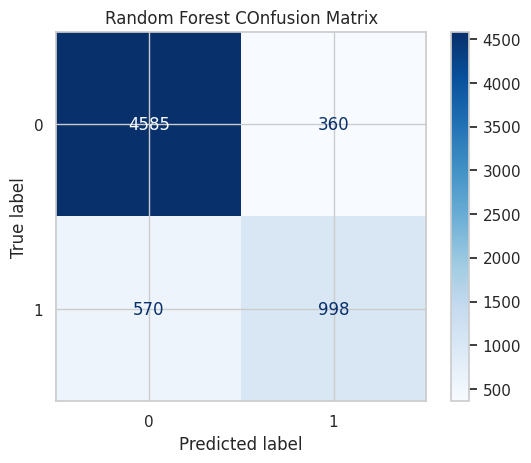

In [ ]:
# TODO: Print the classification report and confusion matrix for the Random Forest model,
# just like we did for Logistic Regression.

# Your code here

#ypred but random forrest _rf
print('\n RF Classification Report:')
print(classification_report(y_test, y_pred_rf))



rfcm= confusion_matrix(y_test, y_pred_rf)
rfdsip=ConfusionMatrixDisplay(confusion_matrix=rfcm, display_labels=rf_clf.classes_ )
rfdsip.plot(cmap='Blues')
plt.title('Random Forest COnfusion Matrix')
plt.show()



In [ ]:
# TODO: Use cross_val_score to compare Logistic Regression and Random Forest via cross-validated accuracy.
# HINT: You can reuse log_reg_clf and rf_clf, and run cross_val_score for each.


# Your code here
log_reg_scores=cross_val_score(log_reg_clf, X_train, y_train, cv=5, scoring='accuracy')
rf_scores=cross_val_score(rf_clf,X_train, y_train, cv=5, scoring='accuracy')
print(log_reg_scores.mean())
print(rf_scores.mean())
print("Logistic Regression" if log_reg_scores.mean() > rf_scores.mean() else "Random Forest", "is more accurate")


0.8508904380392861
0.8511591888982931
Random Forest is more accurate


## 7. Hyperparameter Tuning with Optuna

Model performance can often be improved by tuning **hyperparameters** (settings you choose before training).
For example, Random Forest has hyperparameters like `n_estimators`, `max_depth`, and `max_features`.

**Optuna** is a library that automates hyperparameter search.

**Why this matters:**
- Hand-tuning hyperparameters is time-consuming and error-prone.
- A systematic search can find better configurations more efficiently.

**Resources**:
- Optuna docs: https://optuna.readthedocs.io/  
- Optuna + scikit-learn example: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html


In [ ]:
def objective(trial: optuna.Trial) -> float:
    """Objective function for Optuna hyperparameter search.

    We will tune a RandomForestClassifier inside our preprocessing pipeline.
    The goal is to maximize cross-validated accuracy.
    """

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    rf = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )),
    ])

    # Use cross-validation on the training set
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()


In [ ]:
# TODO: Create and run an Optuna study to optimize the Random Forest hyperparameters.
# HINTS:
# - study = optuna.create_study(direction='maximize')
# - study.optimize(objective, n_trials=20)
# - Print study.best_trial.value and study.best_trial.params

# WARNING: Increasing n_trials will improve the search but take longer.

# Your code here
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=5)
print(study.best_trial.value, study.best_trial.params )

[I 2025-12-27 02:22:15,945] A new study created in memory with name: no-name-0af3a1fe-9185-42e4-94ae-ea422bc402c0
[I 2025-12-27 02:22:42,779] Trial 0 finished with value: 0.8575706192400906 and parameters: {'n_estimators': 228, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8575706192400906.
[I 2025-12-27 02:23:20,011] Trial 1 finished with value: 0.8601043455492582 and parameters: {'n_estimators': 286, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8601043455492582.
[I 2025-12-27 02:23:28,447] Trial 2 finished with value: 0.8356495872268934 and parameters: {'n_estimators': 281, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8601043455492582.
[I 2025-12-27 02:23:41,706] Trial 3 finished with value: 0.8572634880364615 and parameters: {'n_estimators': 119, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 1 with val

0.8601043455492582 {'n_estimators': 286, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 4}


## 8. Train Final Model with Best Hyperparameters

Once we have the best hyperparameters from Optuna, we can:
- Rebuild the Random Forest pipeline using those parameters.
- Fit it on the **full training set**.
- Evaluate on the test set.

**Why this matters:**
- This is the model you would typically save and deploy.
- Using the best-found configuration should give better performance than the untuned baseline.


In [ ]:
# TODO: After running Optuna, use study.best_trial.params to build a final Random Forest pipeline.
# Example structure (you will need to insert the parameters from the study):

# best_params = study.best_trial.params  # requires that you have run the study cell above
# final_rf_clf = Pipeline(steps=[
#     ('preprocess', preprocessor),
#     ('model', RandomForestClassifier(
#         n_estimators=best_params['n_estimators'],
#         max_depth=best_params['max_depth'],
#         min_samples_split=best_params['min_samples_split'],
#         min_samples_leaf=best_params['min_samples_leaf'],
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#     )),
# ])
#
# final_rf_clf.fit(X_train, y_train)
# y_pred_final = final_rf_clf.predict(X_test)
#
# print('Final tuned Random Forest accuracy:', accuracy_score(y_test, y_pred_final))
# print(classification_report(y_test, y_pred_final))

# Your code here
best_params = study.best_trial.params
final_rf_clf = Pipeline(steps=[
     ('preprocess', preprocessor),
   ('model', RandomForestClassifier(
         n_estimators=best_params['n_estimators'],
         max_depth=best_params['max_depth'],
         min_samples_split=best_params['min_samples_split'],
         min_samples_leaf=best_params['min_samples_leaf'],
         random_state=RANDOM_STATE,
         n_jobs=-1,
     )),

 ])

final_rf_clf.fit(X_train, y_train)
y_pred_final= final_rf_clf.predict(X_test)
print('Final Random Forest Accuracy:',accuracy_score(y_test, y_pred_final) )
print(classification_report(y_test, y_pred_final))

Final Random Forest Accuracy: 0.8674957776754184
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.79      0.61      0.69      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



## 9. Wrap-Up and Next Steps

In this notebook, you walked through an end-to-end data science project:

1. **Defined the problem** (binary income classification on census data).
2. **Loaded and explored the data** (EDA: missing values, distributions, relationships).
3. **Preprocessed the data** using scikit-learn pipelines (imputation, scaling, one-hot encoding).
4. **Trained baseline and advanced models** (Logistic Regression, Random Forest).
5. **Evaluated model performance** with accuracy, classification reports, and confusion matrices.
6. **Used Optuna** to tune hyperparameters for better performance.
7. **Prepared a final tuned model** (exercise) that you could save and deploy.

**Next ideas to explore**:
- Try different models: Gradient Boosting, XGBoost, LightGBM.
- Explore additional metrics (e.g., ROC AUC, precision/recall curves).
- Investigate fairness and bias in predictions across demographic groups.
- Package your code into reusable Python modules.

Great job making it this far! 🎉
